gradient boosting

Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.83        53
           1       1.00      0.67      0.80        63

    accuracy                           0.82       116
   macro avg       0.86      0.83      0.82       116
weighted avg       0.87      0.82      0.82       116

Confusion Matrix:
[[53  0]
 [21 42]]


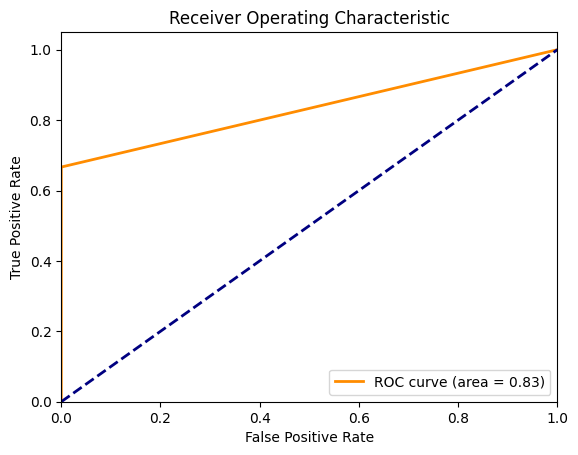

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

# Load data
data = pd.read_csv('dataset_for_cancersequences.csv')

# Feature engineering (e.g., GC content, k-mers)
data['GC_content'] = data['Sequence'].apply(lambda seq: (seq.count('G') + seq.count('C')) / len(seq))
k_mer_features = data['Sequence'].apply(lambda x: k_mer_frequencies(x, k=4))
k_mer_df = pd.DataFrame(k_mer_features.tolist()).fillna(0)
data = pd.concat([data, k_mer_df], axis=1)

# Extract features and target
X = data.drop(columns=['Sequence', 'Label', 'ID', 'Cancer name', 'Gene Name'])  # Drop non-numeric columns including 'Cancer name'
y = data['Label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Feature selection using RandomForestClassifier
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
X_train_selected = feature_selector.fit_transform(X_train, y_train)
X_test_selected = feature_selector.transform(X_test)

# Model training and hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_selected, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predictions and evaluation
y_pred = best_model.predict(X_test_selected)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC Curve
y_pred_prob = best_model.predict_proba(X_test_selected)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


random forest

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Load your data
data = pd.read_csv('/content/dataset_for_cancersequences_reduced.csv')

# Print column names and data types to inspect
print(data.columns)
print(data.dtypes)  # Check data types of each column

# Identify categorical columns (including 'Label' if it needs encoding)
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

# Check if 'Label' is in the list and remove it if necessary
if 'Label' in categorical_cols:
    categorical_cols.remove('Label')  # Remove 'Label' if it's your target variable

# Handle non-numerical columns using OneHotEncoder
# OneHotEncoder is generally preferred for categorical features with no ordinal relationship
ohe = OneHotEncoder(handle_unknown='ignore')  # 'ignore' handles new categories in test data
encoded_data = pd.DataFrame(ohe.fit_transform(data[categorical_cols]).toarray())
encoded_data = encoded_data.add_prefix('OHE_')  # Add prefix to encoded column names

# Concatenate encoded data with original dataframe
data = pd.concat([data, encoded_data], axis=1)

# Encode the target variable 'Label' if it's categorical
label_encoder = LabelEncoder()
data['Label_encoded'] = label_encoder.fit_transform(data['Label'])

# Drop original categorical columns and the unencoded 'Label'
X = data.drop(['Label'] + categorical_cols, axis=1)
y = data['Label_encoded']  # Use the encoded target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameters for Random Forest
param_dist_rf = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize Random Forest model
rf = RandomForestClassifier()

# Use RandomizedSearchCV for hyperparameter tuning
rand_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, scoring='accuracy', cv=5, n_iter=100, random_state=42, n_jobs=-1)
rand_search_rf.fit(X_train, y_train)
best_rf = rand_search_rf.best_estimator_

# Predictions
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Evaluation
accuracy_rf = accuracy_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"Confusion Matrix:\n{cm_rf}")
print(f"Classification Report:\n{report_rf}")
print(f"ROC AUC: {roc_auc_rf:.4f}")


Index(['ID', 'Sequence', 'Cancer name', 'Gene Name', 'Label'], dtype='object')
ID              int64
Sequence       object
Cancer name    object
Gene Name      object
Label           int64
dtype: object


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Random Forest Accuracy: 1.0000
Confusion Matrix:
[[ 2  0]
 [ 0 10]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        10

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

ROC AUC: 1.0000


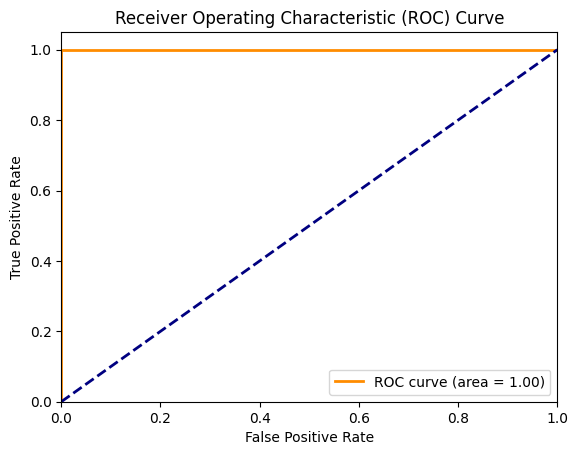

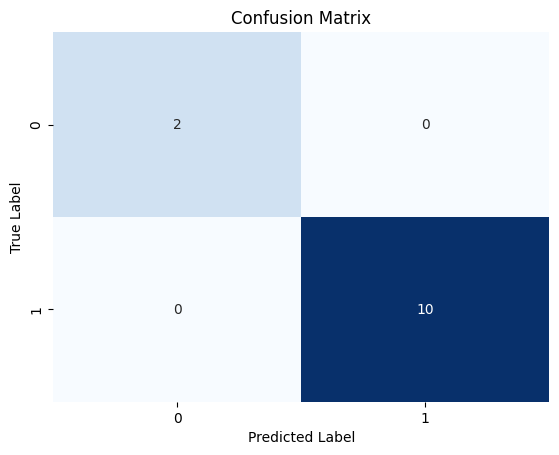

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Confusion Matrix
plt.figure()
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


logistic regression

Epoch 1/100
3/3 [==============================] - 2s 166ms/step - loss: 1.0453 - accuracy: 0.4242 - val_loss: 0.7473 - val_accuracy: 0.4118
Epoch 2/100
3/3 [==============================] - 0s 43ms/step - loss: 0.7117 - accuracy: 0.5455 - val_loss: 0.4993 - val_accuracy: 0.9412
Epoch 3/100
3/3 [==============================] - 0s 36ms/step - loss: 0.6243 - accuracy: 0.6667 - val_loss: 0.3909 - val_accuracy: 0.9412
Epoch 4/100
3/3 [==============================] - 0s 34ms/step - loss: 0.4980 - accuracy: 0.7121 - val_loss: 0.3381 - val_accuracy: 0.8824
Epoch 5/100
3/3 [==============================] - 0s 35ms/step - loss: 0.4903 - accuracy: 0.8182 - val_loss: 0.3095 - val_accuracy: 0.9412
Epoch 6/100
3/3 [==============================] - 0s 36ms/step - loss: 0.5237 - accuracy: 0.7727 - val_loss: 0.2917 - val_accuracy: 0.9412
Epoch 7/100
3/3 [==============================] - 0s 25ms/step - loss: 0.4128 - accuracy: 0.8333 - val_loss: 0.2793 - val_accuracy: 0.9412
Epoch 8/100
3/3 [==

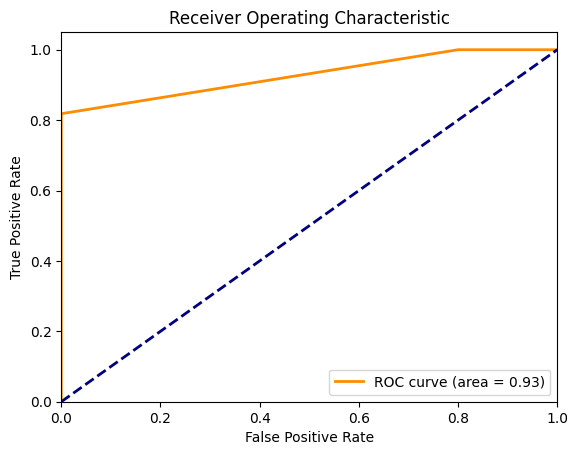

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('dataset_for_cancersequences_reduced.csv')

# Feature engineering functions
def calculate_gc_content(sequence):
    gc_content = (sequence.count('G') + sequence.count('C')) / len(sequence)
    return gc_content

def k_mer_frequencies(sequence, k=3):
    k_mer_freqs = {}
    total_k_mers = len(sequence) - k + 1
    for i in range(total_k_mers):
        k_mer = sequence[i:i+k]
        if k_mer in k_mer_freqs:
            k_mer_freqs[k_mer] += 1
        else:
            k_mer_freqs[k_mer] = 1
    for k in k_mer_freqs:
        k_mer_freqs[k] /= total_k_mers
    return k_mer_freqs

# Apply feature engineering
data['GC_content'] = data['Sequence'].apply(calculate_gc_content)
k_mer_features = data['Sequence'].apply(lambda x: k_mer_frequencies(x, k=3))

# Merge k-mer features with GC content
k_mer_df = pd.DataFrame(k_mer_features.tolist()).fillna(0)
data = pd.concat([data, k_mer_df], axis=1)

# Extract features and target
X = data.drop(columns=['Sequence', 'Label', 'ID', 'Cancer name', 'Gene Name'])  # Drop non-numeric columns
y = data['Label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Build a simple neural network
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Predictions and evaluation
y_pred = (model.predict(X_test) > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC Curve
y_pred_prob = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
!pip install numpy pandas scikit-learn tensorflow keras imbalanced-learn gensim optuna transformers biopython
! pip install pandas numpy matplotlib scipy biopython
!pip install numpy pandas scikit-learn tensorflow imbalanced-learn optuna
!pip install pandas numpy scikit-learn keras hyperopt seaborn matplotlib biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.8 MB/s eta 0:00:00


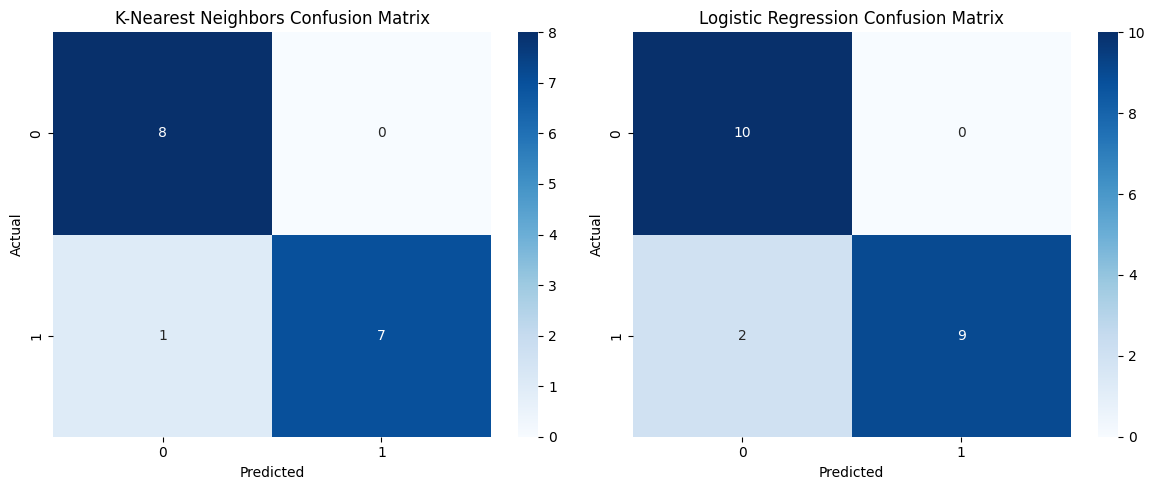

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# KNN Confusion Matrix
knn_cm = np.array([[8, 0], [1, 7]])

# Logistic Regression Confusion Matrix
logistic_cm = np.array([[10, 0], [2, 9]])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# KNN Confusion Matrix Plot
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('K-Nearest Neighbors Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Logistic Regression Confusion Matrix Plot
sns.heatmap(logistic_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Logistic Regression Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


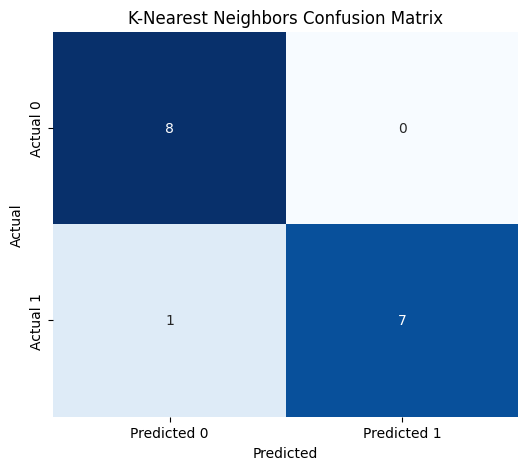

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# KNN Confusion Matrix
knn_cm = np.array([[8, 0], [1, 7]])

# Plot KNN Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('K-Nearest Neighbors Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


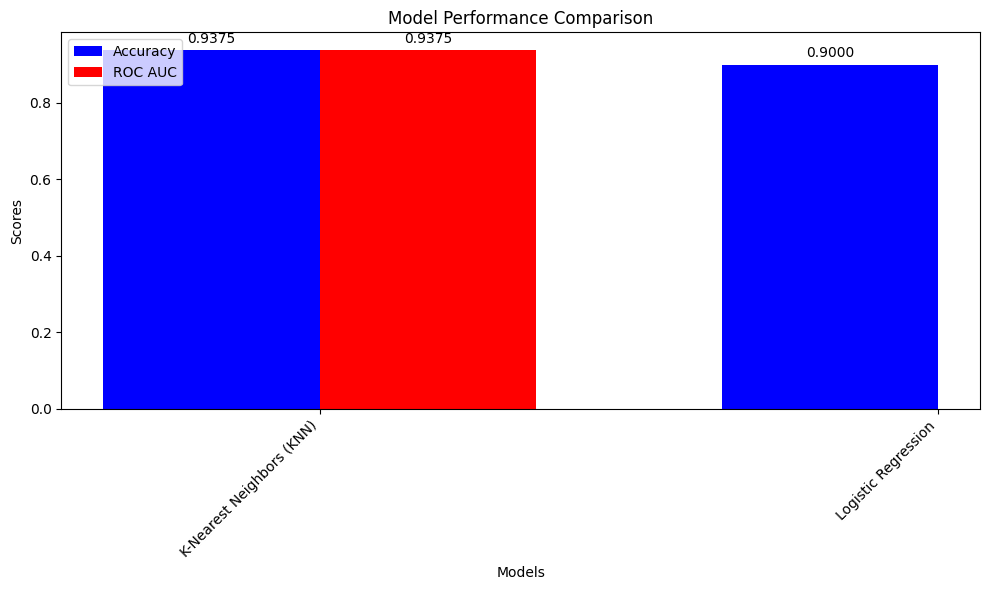

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['K-Nearest Neighbors (KNN)', 'Logistic Regression']
accuracy = [0.9375, 0.9]
roc_auc = [0.9375, np.nan]  # Use NaN for missing ROC AUC value

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.35

# Position of bars
index = np.arange(len(models))

# Create bars for Accuracy
bars1 = ax.bar(index - bar_width/2, accuracy, bar_width, label='Accuracy', color='b')

# Create bars for ROC AUC
bars2 = ax.bar(index + bar_width/2, roc_auc, bar_width, label='ROC AUC', color='r')

# Adding labels
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

# Adding value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


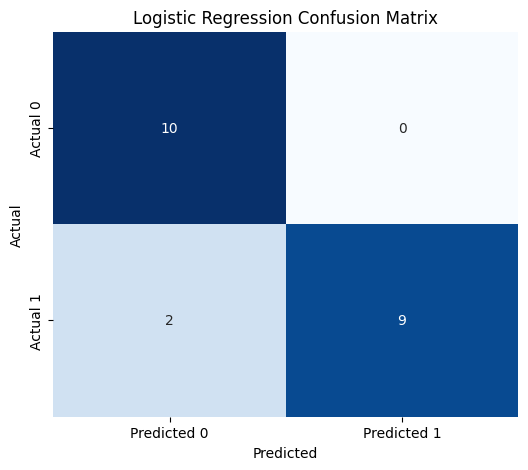

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Logistic Regression Confusion Matrix
logistic_cm = np.array([[10, 0], [2, 9]])

# Plot Logistic Regression Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(logistic_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


knn

Index(['ID', 'Sequence', 'Cancer name', 'Gene Name', 'Label'], dtype='object')
ID              int64
Sequence       object
Cancer name    object
Gene Name      object
Label           int64
dtype: object
KNN Accuracy: 0.9375
Confusion Matrix:
[[8 0]
 [1 7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16

ROC AUC: 0.9375


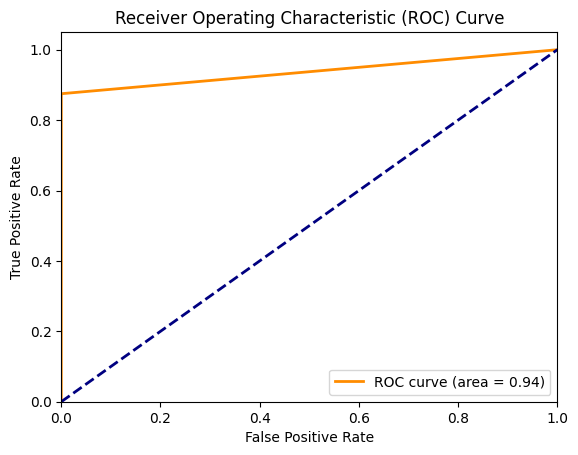

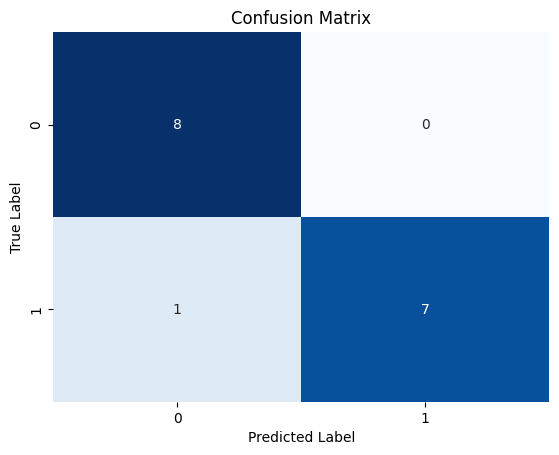

In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
data = pd.read_csv('/content/dataset_for_cancersequences.csv')

# Print column names and data types to inspect
print(data.columns)
print(data.dtypes)

# Identify categorical columns (excluding 'Label')
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
if 'Label' in categorical_cols:
    categorical_cols.remove('Label')

# One-Hot Encode categorical features
ohe = OneHotEncoder(handle_unknown='ignore')
encoded_data = pd.DataFrame(ohe.fit_transform(data[categorical_cols]).toarray())
encoded_data = encoded_data.add_prefix('OHE_')
data = pd.concat([data, encoded_data], axis=1)

# Encode the target variable 'Label' if it's categorical
label_encoder = LabelEncoder()
data['Label_encoded'] = label_encoder.fit_transform(data['Label'])

# Drop original categorical columns and the unencoded 'Label'
X = data.drop(['Label'] + categorical_cols, axis=1)
y = data['Label_encoded']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance
# Initial oversampling with RandomOverSampler to ensure at least 2 samples in minority class
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_scaled, y)

# Further balance the dataset with SMOTE if applicable
unique, counts = np.unique(y_resampled, return_counts=True)
if min(counts) > 1:  # Check if SMOTE can be applied
    smote = SMOTE(random_state=42, k_neighbors=min(counts)-1)
    X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Define hyperparameters for KNeighborsClassifier
param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize KNeighborsClassifier model
knn = KNeighborsClassifier()

# Use GridSearchCV for hyperparameter tuning
grid_search_knn = GridSearchCV(knn, param_grid=param_grid_knn, scoring='accuracy', cv=5, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)
best_knn = grid_search_knn.best_estimator_

# Predictions
y_pred_knn = best_knn.predict(X_test)

# Check the shape of predict_proba output
proba_shape = best_knn.predict_proba(X_test).shape

# Handle the case of single-column output
if proba_shape[1] == 1:
    y_proba_knn = best_knn.predict_proba(X_test)[:, 0]  # Use the first (and only) column
else:
    y_proba_knn = best_knn.predict_proba(X_test)[:, 1]  # Use the second column as intended

# Evaluation
accuracy_knn = accuracy_score(y_test, y_pred_knn)
cm_knn = confusion_matrix(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_proba_knn)

print(f"KNN Accuracy: {accuracy_knn:.4f}")
print(f"Confusion Matrix:\n{cm_knn}")
print(f"Classification Report:\n{report_knn}")
print(f"ROC AUC: {roc_auc_knn:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_knn)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Confusion Matrix
plt.figure()
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


xg boost

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.81      1.00      0.89        62

    accuracy                           0.81        77
   macro avg       0.40      0.50      0.45        77
weighted avg       0.65      0.81      0.72        77

Confusion Matrix:
[[ 0 15]
 [ 0 62]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


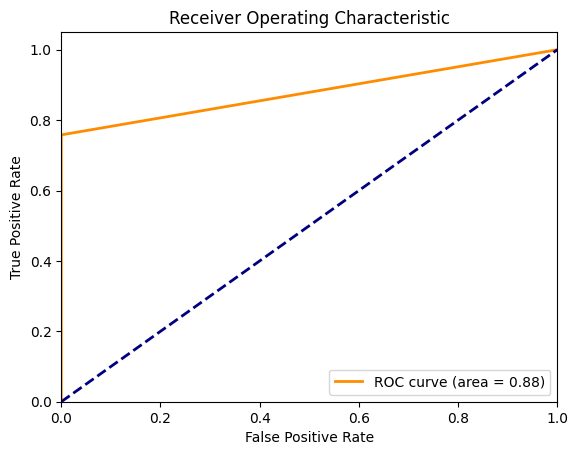

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('dataset_for_cancersequences.csv')

# Feature engineering functions
def calculate_gc_content(sequence):
    gc_content = (sequence.count('G') + sequence.count('C')) / len(sequence)
    return gc_content

def k_mer_frequencies(sequence, k=3):
    k_mer_freqs = {}
    total_k_mers = len(sequence) - k + 1
    for i in range(total_k_mers):
        k_mer = sequence[i:i+k]
        if k_mer in k_mer_freqs:
            k_mer_freqs[k_mer] += 1
        else:
            k_mer_freqs[k_mer] = 1
    for k in k_mer_freqs:
        k_mer_freqs[k] /= total_k_mers
    return k_mer_freqs

# Apply feature engineering
data['GC_content'] = data['Sequence'].apply(calculate_gc_content)
k_mer_features = data['Sequence'].apply(lambda x: k_mer_frequencies(x, k=3))

# Merge k-mer features with GC content
k_mer_df = pd.DataFrame(k_mer_features.tolist()).fillna(0)
data = pd.concat([data, k_mer_df], axis=1)

# Extract target variable and features
X = k_mer_df.copy()
y = data['Label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model training with hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# ROC Curve
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
